In [1]:
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from keras.layers import Add, Reshape, Flatten
from keras import backend as K
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from ImageUtils import ImageUtils
import pickle
from keras import regularizers

D:\sf\conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#基本常量
sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimages'
targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimagesResize320'
root = 'D:/jupyter/car-management/recognitionalgorithm/dataset'
Xfilename = 'licenseplateL.npy'
Yfilename = 'label.npy'
filename = '字典.xlsx'

In [19]:
#加载图片数据
utils = ImageUtils()

(1222, 320, 320, 3)
(1222, 7)
云D86999


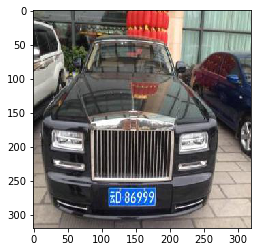

In [20]:
#检查图片数据
X_train, Y_train = utils.load(root, Xfilename, Yfilename)
print(X_train.shape)
print(Y_train.shape)
print(utils.getLabel(root, filename, Y_train[10]))
plt.imshow(X_train[10])

In [2]:
def identify_block(X, filters, name, strides):
    conv_name = 'identify_conv' + str(name)
    bn_name = 'identify_bn_name' + str(name)
    activation_name = 'identify_activation_name' + str(name)
    add_name = 'identify_add' + str(name)
    skip_name = 'identify_skip' + str(name)
    
    f_1_1, f_1_2, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (3, 3), strides = strides, padding = 'same', name = conv_name + '_1_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    bn_1_1 = BatchNormalization(name = bn_name + '_1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '_1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '_2_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '_2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '_2_1')(bn_2_1)
    
    '''skip unit'''
    skip_strides = 2 * strides
    if strides == 1:
        skip_strides = 1
        
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, padding = 'same', name = skip_name + '_1_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    
    identify = Add(name = add_name + '_1_1')([activation_2_1, conv_skip_1_1])
    
    return identify

In [3]:
'''build convlution block'''
def bottleneck_block(X, filters, name, strides):
    conv_name = 'bk_conv' + str(name)
    bn_name = 'bk_bn' + str(name)
    activation_name = 'bk_an' + str(name)
    add_name = 'bk_add' + str(name)
    skip_name = 'bk_sk' + str(name)
    
    f_1_1, f_1_2, f_1_3, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (1, 1), strides = strides, padding = 'same', name = conv_name + '1_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    bn_1_1 = BatchNormalization(name = bn_name + '1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '2_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '2_1')(bn_2_1)
    
    '''skip unit'''
    conv_3_1 = Conv2D(f_1_3, (1, 1), strides = strides, padding = 'same', name = conv_name + '3_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(activation_2_1)
    bn_3_1 = BatchNormalization(name = bn_name + '3_1')(conv_3_1)
    activation_3_1 = Activation('relu', name = activation_name + '3_1')(bn_3_1)
    
    '''skip unit'''
    skip_strides = int(pow(strides, 3))
    if strides == 1:
        skip_strides = 1
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, name = skip_name + 'c_1_1', padding = 'same', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    bn_skip_1_1 = BatchNormalization(name = skip_name + '_1_1')(conv_skip_1_1)
    activation_skip_1_1 = Activation('relu', name = skip_name + 'an_1_1')(bn_skip_1_1)
    
    
    bottleneck = Add(name = add_name + '_1_1')([activation_3_1, activation_skip_1_1])
    
    return bottleneck

In [4]:
'''build full network'''
def resnet(input_shape, full_conncet_nums = (512, 7)):
    '''inputs'''
    inputs = Input(shape = input_shape)
    
    
    '''128 filters, identify name: 1  256 filters, bottleneck name: 1'''
    bottleneck_block_1 = bottleneck_block(inputs, filters = (128, 128, 128, 128), name = 1, strides = 2)
    identify_block_1 = identify_block(bottleneck_block_1, filters = (256, 256, 256), name = 1, strides = 1)
    
    
    '''max pooling'''
    mp2d = MaxPooling2D(pool_size = (2, 2))(identify_block_1)
    
    '''relu activation'''
    an_block_1 = Activation('relu', name = 'model_an_1')(mp2d)
    
    '''dropout'''
    d_bottleneck_block_1 = Dropout(0.25)(an_block_1)
    
    '''256 filters, identify name: 2  512 filters, bottleneck name: 2'''
    bottleneck_block_2 = bottleneck_block(d_bottleneck_block_1, filters = (512, 512, 512, 512), name = 2, strides = 1)
    identify_block_2 = identify_block(bottleneck_block_2, filters = (1024, 1024, 1024), name = 2, strides = 1)
    
    '''relu activation'''
    an_block_2 = Activation('relu', name = 'model_an_2')(identify_block_2)
    
    '''dropout'''
    d_bottleneck_block_2 = Dropout(0.25)(an_block_2)
    
    '''1024 filters, identify name: 2  2048 filters, bottleneck name: 2'''
#     bottleneck_block_3 = bottleneck_block(d_bottleneck_block_2, filters = (1024, 1024, 1024, 1024), name = 3, strides = 2)
#     identify_block_3 = identify_block(d_bottleneck_block_2, filters = (2048, 2048, 2048), name = 3, strides = 2)
    
    '''average pooling'''
    ap2d = AveragePooling2D(pool_size = (1, 1))(d_bottleneck_block_2)
    
    '''dropout 0.05'''
    d_bottleneck_block_3 = Dropout(0.5)(ap2d)
    
    
    '''flatten'''
    flatten = Flatten()(d_bottleneck_block_3)
    
    '''full connect params'''
    full_connect_num_1, full_connect_num_2 = full_conncet_nums
    
    '''full connect layer 1'''
    full_connect1 = Dense(full_connect_num_1, activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.1))(flatten)
    
  
    '''full conncet layer 2'''
    end_full_connect = Dense(full_connect_num_2, activation = 'softmax', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.1))(full_connect1)

    '''build model'''
    model = Model(inputs = inputs, outputs = end_full_connect)
    
    return model

In [5]:
'''build model obejct'''
model = resnet(input_shape = (320, 320, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
bk_conv11_1 (Conv2D)            (None, 160, 160, 128 512         input_1[0][0]                    
__________________________________________________________________________________________________
bk_bn11_1 (BatchNormalization)  (None, 160, 160, 128 512         bk_conv11_1[0][0]                
__________________________________________________________________________________________________
bk_an11_1 (Activation)          (None, 160, 160, 128 0           bk_bn11_1[0][0]                  
__________________________________________________________________________________________________
bk_conv12_

In [10]:
plot_model(model, to_file='resnet_model1.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [16]:
'''test model'''
inputs = np.random.rand(5, 320, 320, 3)
model.predict(inputs)

array([[2.95166075e-02, 3.14072636e-03, 1.71656338e-05, 2.55471357e-04,
        1.78040689e-04, 9.66890752e-01, 1.31486320e-06],
       [1.60860568e-01, 2.48796795e-03, 1.73997923e-05, 1.50774707e-04,
        1.02524878e-04, 8.36380124e-01, 7.19404227e-07],
       [4.66179401e-02, 6.06348913e-04, 3.78257646e-05, 9.25019631e-05,
        9.01411404e-05, 9.52554464e-01, 7.52346921e-07],
       [4.41746749e-02, 6.77105680e-04, 2.04901353e-05, 9.73446586e-05,
        4.91224455e-05, 9.54980969e-01, 3.53320019e-07],
       [1.07831895e-01, 1.28591142e-03, 8.76783270e-06, 6.12076692e-05,
        5.92523029e-05, 8.90752494e-01, 5.28443763e-07]], dtype=float32)

In [17]:
'''compile model'''
model.compile(loss = 'mean_squared_error', optimizer = 'adadelta', metrics = ['accuracy'])

In [ ]:
'''train model'''
model.fit(X_train, Y_train, batch_size = 8, epochs = 5)

Epoch 1/5


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 320, 320, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 157, 157, 64) 3200        reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 157, 157, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [18]:
config_file = 'config_file.pickle'

In [36]:
config = model.get_config()
with open(config_file, 'wb') as f:
    pickle.dump({'config': config}, f)
    

In [23]:
weights_resnet_1 = 'weights_resnet_1.h5'
model.save_weights(weights_resnet_1)

云D86999


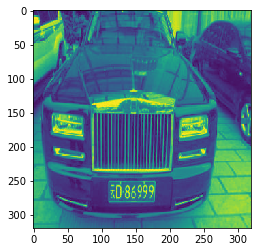

In [35]:
# X = X_train[10]
# y = model.predict(X.reshape((1, 320, 320)))
plt.imshow(X_train[10])
print(utils.getLabel(root, filename, Y_train[10]))